In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

from sklearn.cluster import KMeans

from skimage.morphology import opening, closing, disk

from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage as ndi

In [2]:
import scipy.io as sio

mat = sio.loadmat("ground_truth/test/2018.mat")
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'groundTruth'])


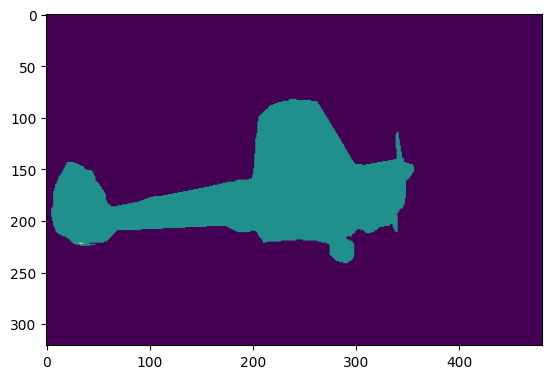

In [3]:
import matplotlib.pyplot as plt
mat = sio.loadmat("ground_truth/test/3063.mat")
gt = mat["groundTruth"]
segmentation = gt[0,0]["Segmentation"][0,0] #first annotator

plt.imshow(segmentation)

In [4]:
IMAGE_DIR = "images/test"
MAT_DIR   = "ground_truth/test"

In [5]:
def load_mask(mat_path, annotator_id=0):

    mat = sio.loadmat(mat_path)
    seg = mat["groundTruth"][0, 0]["Segmentation"][0, annotator_id]
    return (seg > 0).astype(np.uint8)

In [7]:
def iou_score(pred, gt):
    inter = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return inter / union if union > 0 else 0

In [8]:
def k_means(image, k=2, closing_radius=5):
    Z = image.reshape((-1, 3)).astype(np.float32)
    labels = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(Z)
    labels = labels.reshape(image.shape[:2])


    vals, counts = np.unique(labels, return_counts=True)
    fg_label = vals[np.argmax(counts)]
    mask = (labels == fg_label).astype(np.uint8)

    if closing_radius > 0:
        mask = closing(mask, disk(closing_radius)).astype(np.uint8)

    return mask

In [9]:
def canny(img, sigma=0.5, closing_radius=0):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    v = np.median(gray)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edges = cv2.Canny(gray, lower, upper)
    
    if closing_radius > 0:
        edges = closing(edges.astype(bool), disk(closing_radius)).astype(np.uint8)
    return edges

In [10]:
def watershed_segmentation(image, footprint=3, closing_radius=0):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    distance = ndi.distance_transform_edt(binary)

    coords = peak_local_max(distance, labels=binary, footprint=np.ones((footprint, footprint)))
    local_max = np.zeros_like(distance, dtype=bool)
    if coords.size > 0:
        local_max[tuple(coords.T)] = True

    markers = ndi.label(local_max)[0]

    labels = watershed(-distance, markers, mask=binary)

    mask = (labels > 0).astype(np.uint8)

    if closing_radius > 0:
        mask = closing(mask, disk(closing_radius)).astype(np.uint8)

    return mask


In [18]:
# --- KMeans Grid Search ---
param_grid_kmeans = {
    "k": [2, 3, 4],
    "closing_radius": [0, 3, 5]
}

best_score, best_params = 0, None

for k in param_grid_kmeans["k"]:
    for cr in param_grid_kmeans["closing_radius"]:
        scores = []
        for fname in os.listdir(IMAGE_DIR):
            if not fname.endswith(".jpg"):
                continue
            img = cv2.imread(os.path.join(IMAGE_DIR, fname))
            gt = load_mask(os.path.join(MAT_DIR, fname.replace(".jpg", ".mat")))

            pred = k_means(img, k=k, closing_radius=cr)
            scores.append(iou_score(pred, gt))

        mean_iou = np.mean(scores)
        print(f"KMeans | k={k}, closing_radius={cr} -> IoU={mean_iou:.3f}")

        if mean_iou > best_score:
            best_score = mean_iou
            best_params = (k, cr)

print("En iyi KMeans:", best_params, "IoU:", best_score)

KMeans | k=2, closing_radius=0 -> IoU=0.664
KMeans | k=2, closing_radius=3 -> IoU=0.741
KMeans | k=2, closing_radius=5 -> IoU=0.776
KMeans | k=3, closing_radius=0 -> IoU=0.488
KMeans | k=3, closing_radius=3 -> IoU=0.595
KMeans | k=3, closing_radius=5 -> IoU=0.649
KMeans | k=4, closing_radius=0 -> IoU=0.395
KMeans | k=4, closing_radius=3 -> IoU=0.510
KMeans | k=4, closing_radius=5 -> IoU=0.568
En iyi KMeans: (2, 5) IoU: 0.7764643687540882


In [21]:
# ---Canny Grid search---

param_grid_canny = {
    "sigma": [0.2, 0.33, 0.5],
    "closing_radius": [0, 3, 5]
}

best_score, best_params = 0, None

for sigma in param_grid_canny["sigma"]:
    for cr in param_grid_canny["closing_radius"]:
        scores = []
        for fname in tqdm(os.listdir(IMAGE_DIR)):
            if not fname.endswith(".jpg"):
                continue
            img = cv2.imread(os.path.join(IMAGE_DIR, fname))
            gt = load_mask(os.path.join(MAT_DIR, fname.replace(".jpg", ".mat")))
            
            pred = canny(img, sigma=sigma, closing_radius=cr)
            scores.append(iou_score(pred, gt))
        
        mean_iou = np.mean(scores)
        print(f"sigma={sigma}, closing_radius={cr} -> IoU={mean_iou:.3f}")
        
        if mean_iou > best_score:
            best_score = mean_iou
            best_params = (sigma, cr)

print("En iyi parametreler:", best_params, "IoU:", best_score)

100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [00:02<00:00, 72.97it/s]


sigma=0.2, closing_radius=0 -> IoU=0.162


100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [00:03<00:00, 54.70it/s]


sigma=0.2, closing_radius=3 -> IoU=0.444


100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [00:06<00:00, 32.54it/s]


sigma=0.2, closing_radius=5 -> IoU=0.520


100%|███████████████████████████████████████████████████████████████████████████████| 201/201 [00:01<00:00, 119.76it/s]


sigma=0.33, closing_radius=0 -> IoU=0.166


100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [00:03<00:00, 53.62it/s]


sigma=0.33, closing_radius=3 -> IoU=0.449


100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [00:06<00:00, 31.97it/s]


sigma=0.33, closing_radius=5 -> IoU=0.519


100%|███████████████████████████████████████████████████████████████████████████████| 201/201 [00:01<00:00, 121.05it/s]


sigma=0.5, closing_radius=0 -> IoU=0.172


100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [00:03<00:00, 53.54it/s]


sigma=0.5, closing_radius=3 -> IoU=0.462


100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [00:06<00:00, 31.78it/s]

sigma=0.5, closing_radius=5 -> IoU=0.527
En iyi parametreler: (0.5, 5) IoU: 0.5270993063516428


In [59]:
# --- Watershed Grid Search ---
param_grid_ws = {
    "closing_radius": [0, 3, 5],
    "footprint": [3, 5, 7]
}

best_score_ws, best_params_ws = 0, None

for cr in param_grid_ws["closing_radius"]:
    for fp in param_grid_ws["footprint"]:
        scores = []
        for fname in os.listdir(IMAGE_DIR):
            if not fname.endswith(".jpg"):
                continue
            img = cv2.imread(os.path.join(IMAGE_DIR, fname))
            gt = load_mask(os.path.join(MAT_DIR, fname.replace(".jpg", ".mat")))

            pred = watershed_segmentation(img, closing_radius=cr, footprint=fp)
            scores.append(iou_score(pred, gt))

        mean_iou = np.mean(scores)
        print(f"Watershed | closing_radius={cr}, footprint={fp} -> IoU={mean_iou:.3f}")

        if mean_iou > best_score_ws:
            best_score_ws = mean_iou
            best_params_ws = (cr, fp)

print("En iyi Watershed:", best_params_ws, "IoU:", best_score_ws)


Watershed | closing_radius=0, footprint=3 -> IoU=0.409
Watershed | closing_radius=0, footprint=5 -> IoU=0.408
Watershed | closing_radius=0, footprint=7 -> IoU=0.407
Watershed | closing_radius=3, footprint=3 -> IoU=0.487
Watershed | closing_radius=3, footprint=5 -> IoU=0.487
Watershed | closing_radius=3, footprint=7 -> IoU=0.483
Watershed | closing_radius=5, footprint=3 -> IoU=0.532
Watershed | closing_radius=5, footprint=5 -> IoU=0.531
Watershed | closing_radius=5, footprint=7 -> IoU=0.530
En iyi Watershed: (5, 3) IoU: 0.5315205860065673


In [63]:
#TEST
ious = {"KMeans": [], "Canny": [], "Watershed": []}

for fname in tqdm(os.listdir(IMAGE_DIR)):
    if not fname.endswith(".jpg"):
        continue

    img_path = os.path.join(IMAGE_DIR, fname)
    mat_path = os.path.join(MAT_DIR, fname.replace(".jpg", ".mat"))

    img = cv2.imread(img_path)
    gt_mask = load_mask(mat_path)

    # --- K-Means ---
    pred_kmeans = k_means(img, k=2, closing_radius=5)
    ious["KMeans"].append(iou_score(pred_kmeans, gt_mask))

    # --- Canny ---
    pred_canny = canny(img, sigma=0.5, closing_radius=5)
    ious["Canny"].append(iou_score(pred_canny, gt_mask))

    # --- Watershed ---
    pred_ws = watershed_segmentation(img, closing_radius=5, footprint=3)
    ious["Watershed"].append(iou_score(pred_ws, gt_mask))

# Ortalama IoU
for method, scores in ious.items():
    print(f"Ortalama {method} IoU: {np.mean(scores):.3f}")

100%|████████████████████████████████████████████████████████████████████████████████| 201/201 [01:02<00:00,  3.23it/s]

Ortalama KMeans IoU: 0.776
Ortalama Canny IoU: 0.527
Ortalama Watershed IoU: 0.532


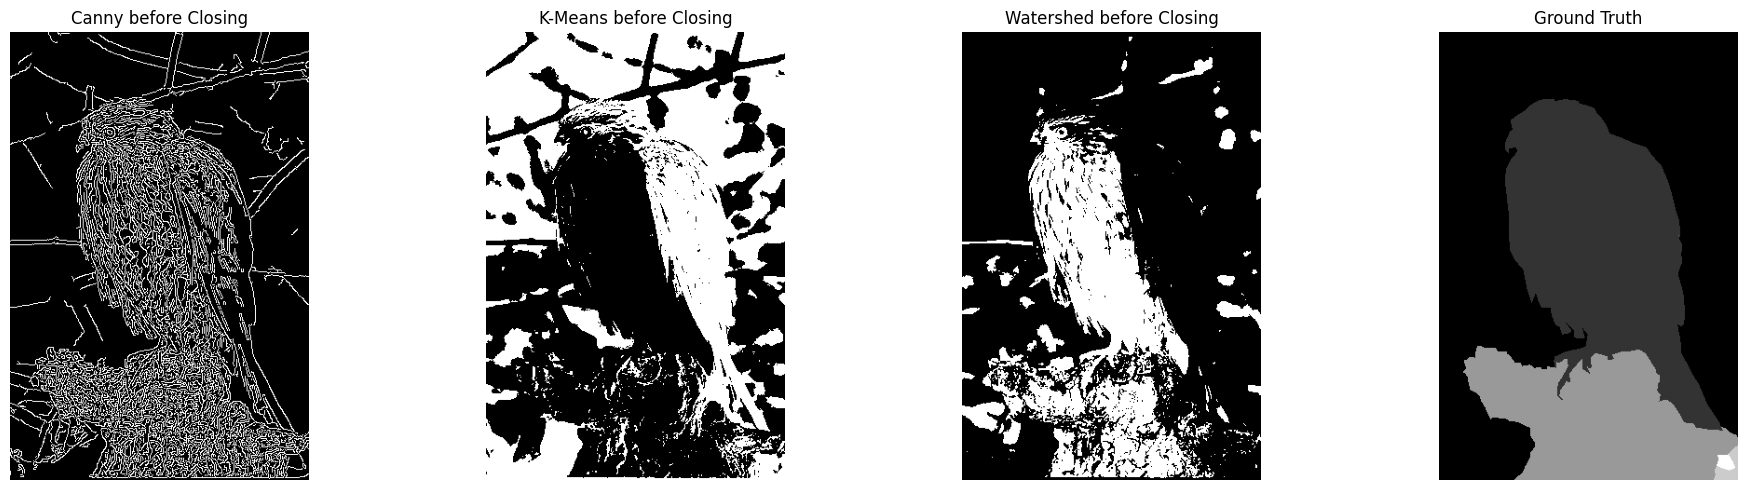

In [12]:
IMAGE_PATH = "images/test/70090.jpg"
MAT_PATH   = "ground_truth/test/70090.mat"

img = cv2.imread(IMAGE_PATH)
mat = sio.loadmat(MAT_PATH)
gt = mat["groundTruth"]
segmentation = gt[0,0]["Segmentation"][0,0]

canny_b = canny(img, sigma=0.5, closing_radius=0) 
kmeans_b = k_means(img, k=3, closing_radius=0)
watershed_b = watershed_segmentation(img, closing_radius=0, footprint=3)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(canny_b, cmap="gray")
axes[0].set_title("Canny before Closing")
axes[0].axis("off")

axes[1].imshow(kmeans_b, cmap="gray")
axes[1].set_title("K-Means before Closing")
axes[1].axis("off")

axes[2].imshow(watershed_b, cmap="gray")
axes[2].set_title("Watershed before Closing")
axes[2].axis("off")

axes[3].imshow(segmentation, cmap="gray")
axes[3].set_title("Ground Truth")
axes[3].axis("off")
plt.tight_layout()
plt.show()


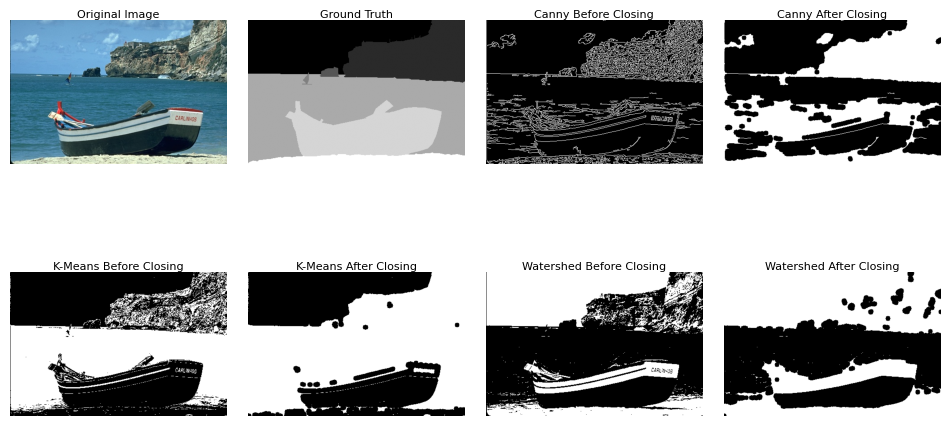

In [60]:
#384022, 112056 #163004
IMG_NO = "384022"
IMAGE_PATH = "images/test/"+ IMG_NO+ ".jpg"
MAT_PATH   = "ground_truth/test/"+ IMG_NO +".mat"

img = cv2.imread(IMAGE_PATH)
mat = sio.loadmat(MAT_PATH)
gt = mat["groundTruth"]
segmentation = gt[0,0]["Segmentation"][0,0]

# Segmentasyonlar

canny_b = canny(img, sigma=0.5, closing_radius=0) 
canny_a = canny(img, sigma=0.5, closing_radius=5) 
kmeans_b = k_means(img, k=3, closing_radius=0) 
kmeans_a = k_means(img, k=3, closing_radius=5)
watershed_b = watershed_segmentation(img, closing_radius=0, footprint=3)
watershed_a = watershed_segmentation(img, closing_radius=5, footprint=3)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))

# --- Orijinal
axes[0,0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axes[0,0].set_title("Original Image", fontsize=8, pad=1)
axes[0,0].axis("off")

# --- Ground Truth
axes[0,1].imshow(segmentation, cmap="gray")
axes[0,1].set_title("Ground Truth", fontsize=8, pad=1)
axes[0,1].axis("off")

# --- Canny
axes[0,2].imshow(canny_b, cmap="gray")
axes[0,2].set_title("Canny Before Closing", fontsize=8, pad=1)
axes[0,2].axis("off")

axes[0,3].imshow(canny_a, cmap="gray")
axes[0,3].set_title("Canny After Closing", fontsize=8, pad=1)
axes[0,3].axis("off")

# --- KMeans
axes[1,0].imshow(kmeans_b, cmap="gray")
axes[1,0].set_title("K-Means Before Closing", fontsize=8, pad=1)
axes[1,0].axis("off")

axes[1,1].imshow(kmeans_a, cmap="gray")
axes[1,1].set_title("K-Means After Closing", fontsize=8, pad=1)
axes[1,1].axis("off")

# --- Watershed
axes[1,2].imshow(watershed_b, cmap="gray")
axes[1,2].set_title("Watershed Before Closing", fontsize=8, pad=1)
axes[1,2].axis("off")

axes[1,3].imshow(watershed_a, cmap="gray")
axes[1,3].set_title("Watershed After Closing", fontsize=8, pad=1)
axes[1,3].axis("off")

plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()
